<a href="https://colab.research.google.com/github/saracasss/machine_learning_cancer_diagnosis/blob/main/BreastCancer_Gene_Expression_Analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MACHINE LEARNING AND BREAST CANCER DIAGNOSTICS**

## **GENE EXPRESSION ANALYSIS**

In [1]:
#!pip install keras-tuner -q

In [2]:
# Import our dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for preprocessing, building, training, and testing regression models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier


# Keras
import tensorflow as tf #for building nn models
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

**READING IN THE DATASET**

In [3]:
bc_df = pd.read_csv('/content/Breast_GSE70947.csv')
bc_df.head()

,samples,type,NM_144987,NM_013290,ENST00000322831,NM_001625,lincRNA:chr7:226042-232442_R,NM_032391,ENST00000238571,XR_108906,...,lincRNA:chr4:77860976-77869926_F,NM_152343,NM_001005327,NM_001039355,lincRNA:chr21:44456656-44468556_R,lincRNA:chr9:4869500-4896050_F,NM_016053,NM_001080425,ENST00000555638,ENST00000508993
0,GSM1823702_252800417016_S01_GE1_107_Sep09_1_2,normal,8.693318,7.718016,6.044438,10.747077,9.133777,4.735581,5.634732,4.670231,...,7.570363,6.368684,4.784042,10.747723,5.090500,5.994149,10.649336,8.969439,4.985693,5.090500
1,GSM1823703_252800417016_S01_GE1_107_Sep09_2_1,normal,9.375980,7.072232,6.976741,10.429671,9.526500,5.221089,5.425187,4.860931,...,7.903335,5.713115,4.421074,11.299200,4.447052,4.421074,10.746854,8.174489,4.464177,4.536891
2,GSM1823704_252800416877_S01_GE1_107_Sep09_2_3,normal,8.943442,7.964573,6.269055,10.825025,9.396855,5.258506,5.824921,4.964604,...,7.705765,6.595364,4.410870,10.576807,5.003699,6.529257,10.430034,8.473468,4.668447,5.084127
3,GSM1823705_252800416894_S01_GE1_107_Sep09_1_1,normal,9.020798,7.824639,6.165165,11.646788,8.776462,4.648655,6.676692,4.770186,...,6.633058,5.786781,4.572984,11.175090,4.990888,6.669871,11.110395,8.880818,4.537626,4.648655
4,GSM1823706_252800416894_S01_GE1_107_Sep09_1_3,normal,8.806154,7.555348,6.230969,11.635247,8.911383,4.518054,6.520691,4.540453,...,6.211581,5.538635,4.613828,12.014365,4.979883,6.414621,10.909805,9.526500,4.670490,4.613828


# **PREPROCESSING**

In [4]:
# How many samples and columns are in the dataset?
num_samples = bc_df.shape[0]
num_columns = bc_df.shape[1]
print(".'"*20)
print(f'Number of Samples: {num_samples}')
print(f'Number of Columns: {num_columns}')
print(".'"*20)

# How many of each type of tissue samples are in the dataset?
type_counts = bc_df['type'].value_counts()
print("Tissue Types and Counts")
print(type_counts)
print(".'"*20)

# Are there duplicate rows?
dup_rows = bc_df.duplicated()
print("Duplicate rows? T/F")
print(dup_rows.value_counts())
print(".'"*20)

# Are there any null values?
# PCA will not work if there are null values
rows_with_null = bc_df[bc_df.isnull().any(axis=1)]
print(f'Null values: {len(rows_with_null)}')
print(".'"*20)

.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'
Number of Samples: 289
Number of Columns: 35983
.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'
Tissue Types and Counts
normal                   146
breast_adenocarcinoma    143
Name: type, dtype: int64
.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'
Duplicate rows? T/F
False    289
dtype: int64
.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'
Null values: 0
.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'.'


In [5]:
#bc_df = bc_df.drop(rows_with_null.index)

In [6]:
# OrdinalENcorder to change categorical values to numerical values
# 1.0 is normal tissue and 0.0 is breast_adenocarcinoma tissue

ord_enc = OrdinalEncoder()
bc_df['type'] = ord_enc.fit_transform(bc_df[['type']])
bc_df['type'].value_counts()

1.0    146
0.0    143
Name: type, dtype: int64

In [7]:
# Drop "samples" column because scaler will not accept a string value
# and the column is unnecessary
bc_df = bc_df.drop(columns='samples')

# separate data into features (X) and target (y)
X = bc_df.drop(columns = "type").values
y = bc_df['type'].values

display(X.shape)
display(y.shape)

(289, 35981)

(289,)

# **SCALING THE DATA**

In [8]:
# scale the features (X) data
# troubleshooting - this section failed because the 'samples' column was a string when the scaler expected a float. dropped the column as it was unneeded.
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X)

# Scale the data
X_scaled = X_scaler.transform(X)


# **PRINCIPLE COMPONENT ANALYSIS**

In [9]:
# PRINCIPLE COMPONENT ANALYSIS
# "The large p, small n problem" [2]
# this section is referencing a kaggle.com submission "Breast cancer Prediction -cancer gene expression" [3]
# troubleshooting - this section did not work at first because of null values in the input X,
# # the issue was corrected by exposing the sample with null values and dropping it from the set.

# set the amount of data to be retained by the final components - 85%
target_variance =0.85

pca = PCA(n_components=target_variance)
pca.fit(X_scaled)
components = len(pca.explained_variance_ratio_)

print(f'Number of Components: {components}')
print("-" * 20)

# The magnitude of each feature within the components
pca_components = np.abs(pca.components_)
print(f'PCA component magnitudes:\n{pca_components[:3]}')
print("-" * 20)

# Variation explained by each component as a ratio
print(f'Explained Variance Ratio: \n {pca.explained_variance_ratio_[:20]}')

Number of Components: 119
--------------------
PCA component magnitudes:
[[0.00017058 0.00358908 0.00460561 ... 0.00229833 0.0003514  0.00194588]
 [0.00201262 0.00141161 0.00272887 ... 0.00786161 0.00018102 0.0006464 ]
 [0.01003232 0.01288561 0.00311774 ... 0.00267283 0.00156296 0.00122485]]
--------------------
Explained Variance Ratio: 
 [0.13800748 0.0618118  0.04451731 0.04149678 0.03539381 0.02936318
 0.02833444 0.0244877  0.02186673 0.0166028  0.0147112  0.01418859
 0.01290568 0.01259053 0.01117864 0.00969771 0.00946453 0.00894229
 0.00819454 0.00794836]


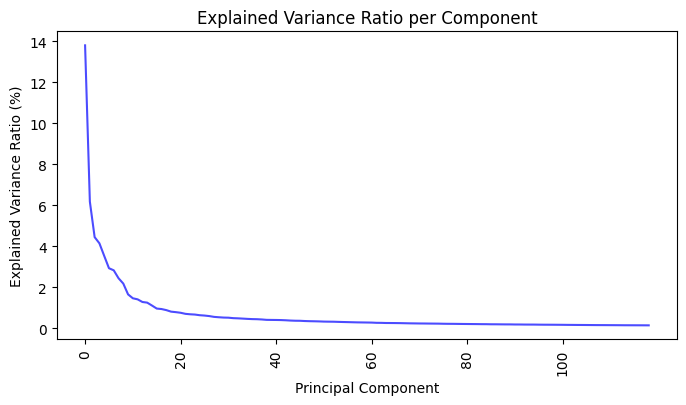

In [10]:
# Variation captured by each component in descending order

ratios = pca.explained_variance_ratio_
ratios_df = pd.DataFrame({'PC': range(len(ratios)), 'ratio': ratios})

plt.figure(figsize=(8,4))
plt.plot(ratios_df['PC'], ratios_df['ratio']*100, color='blue', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio (%)')
plt.title('Explained Variance Ratio per Component')
plt.xticks(ratios_df['PC'][::20],  rotation='vertical')

plt.show()

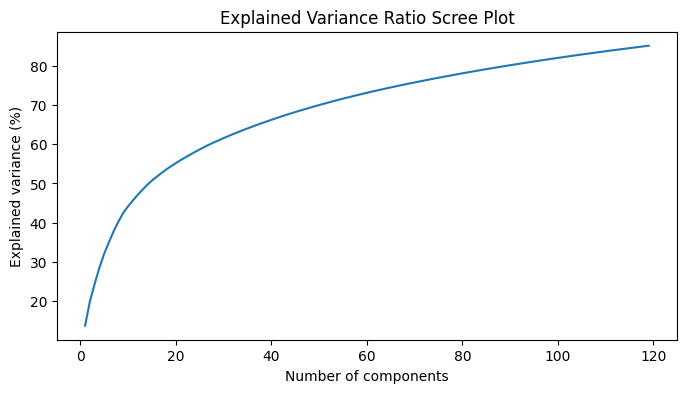

In [11]:
# Make the scree plot [3]
components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(8,4))
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.title('Explained Variance Ratio Scree Plot')

plt.show()

## **SPLIT THE PCA DATA INTO TRAINING AND TESTING SETS**
#### Check the testing data for balanced class distribution.

In [12]:
# transform the features (X_scaled) data onto the principle components
# using the .transform method of the PCA object
X_pca = pca.transform(X_scaled)
print(X_pca.shape)

(289, 119)


In [13]:
# split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=1)

print(f'X_train {X_train.shape}')
print(f'X_test {X_test.shape}')
print(f'y_train {y_train.shape}')
print(f'y_test {y_test.shape}')

print("-" * 20)
y_test_series = pd.Series(y_test)
print(f'y-test class distribution: \n{y_test_series.value_counts()}')

X_train (216, 119)
X_test (73, 119)
y_train (216,)
y_test (73,)
--------------------
y-test class distribution: 
0.0    39
1.0    34
dtype: int64


# **NEURAL NETWORK MODEL**

In [14]:
# Build the deep learning model
# using sigmoid as output layer activation because there is only 2 possible outcomes in this dataset
# number of units in hidden layers is arbiratily chosen
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=X_pca.shape[1]))
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# compile the sequential model together and customize metrics
# this step prepares the model for training and specifies the loss function, optimizer, and metrics to monitor during training
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model to the training data/ aka Train the model
# epochs is the number of times the training data is passed through the neural network
fit_model = nn_model.fit(X_train, y_train, epochs=20)

# Evaluate the model using the test data
#
model_loss, model_accuracy = nn_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/20
7/7 [==============================] - 1s 4ms/step - loss: 6.0848 - accuracy: 0.5417
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 3.6979 - accuracy: 0.5972
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 2.1471 - accuracy: 0.6759
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 1.3373 - accuracy: 0.7269
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8138 - accuracy: 0.7685
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 0.5715 - accuracy: 0.8241
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 0.4224 - accuracy: 0.8565
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 0.3365 - accuracy: 0.8796
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.2694 - accuracy: 0.8935
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.2231 - accuracy: 0.9074
Epoch 11/20
7/7 [======================

This neural network model finished the training cycles with 100% accuracy, but dropped to 72% accuracy with the testing data. This implies the model is overfit to the trianing data. Solutions to try include (1) reducing the number of layers and/or nodes in the model and (2) reducing the number of runs with the taining data [4].

# **NN MODEL OPTIMIZATION WITH KARAS TUNER**

In [15]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=1), activation=activation, input_dim=119))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 2)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=1),
            activation=activation))

    # Provide output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

    return nn_model

In [16]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [17]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [18]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train,y_train,epochs=20,validation_data=(X_test,y_test))

Trial 60 Complete [00h 00m 04s]
val_accuracy: 0.7808219194412231

Best val_accuracy So Far: 0.835616409778595
Total elapsed time: 00h 03m 11s


In [19]:
# Get top 3 model hyperparameters and print the values
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'relu', 'first_units': 3, 'num_layers': 2, 'units_0': 2, 'units_1': 9, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 10, 'num_layers': 2, 'units_0': 4, 'units_1': 6, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'tanh', 'first_units': 9, 'num_layers': 1, 'units_0': 7, 'units_1': 7, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [20]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 1s - loss: 0.5838 - accuracy: 0.8356 - 504ms/epoch - 168ms/step
Loss: 0.5838135480880737, Accuracy: 0.835616409778595
3/3 - 0s - loss: 0.8898 - accuracy: 0.7808 - 459ms/epoch - 153ms/step
Loss: 0.8898386359214783, Accuracy: 0.7808219194412231
3/3 - 1s - loss: 0.5924 - accuracy: 0.7534 - 532ms/epoch - 177ms/step
Loss: 0.5924168229103088, Accuracy: 0.7534246444702148


In [21]:
# Get first best model hyperparameters
first_hyper = tuner.get_best_hyperparameters()[0]
first_hyper.values

{'activation': 'relu',
 'first_units': 3,
 'num_layers': 2,
 'units_0': 2,
 'units_1': 9,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [22]:
# Compare the performance to the keras model
better_model = tuner.get_best_models(2)[1]
model_loss, model_accuracy = better_model.evaluate(X_test,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 1s - loss: 0.8898 - accuracy: 0.7808 - 651ms/epoch - 217ms/step
Loss: 0.8898386359214783, Accuracy: 0.7808219194412231


# **REGRESSION MODEL COMPARISON**
Comparison of models logistic regression, SVM, KNN, and XGBClassifier.

**LOGISTIC REGRESSION MODEL**

In [23]:
# logitstic regression function

def logistic_regression(X_train, y_train, X_test, y_test):
    # Create a Logistic Regression model
    log_reg_model = LogisticRegression(max_iter=1000, random_state=1)

    # Fit the model using training data
    lr_model = log_reg_model.fit(X_train, y_train)

    # Make a prediction using the testing data
    test_predictions = lr_model.predict(X_test)

    # Print the balanced_accuracy score of the model
    accuracy = balanced_accuracy_score(y_test, test_predictions)

    # Generate a confusion matrix for the model
    c_mat = confusion_matrix(y_test, test_predictions)

    # Print results
    print("~"*10 + "LOGISTIC REGRESSION")
    print("Accuracy: %.2f%%" % (accuracy * 100))
    print(f'Confusion matrix: \n{c_mat}')
    print(classification_report(y_test, test_predictions))

**SVM MODEL**

In [24]:
# using SVM Optimizers
from sklearn import svm

def SVC(X_train, y_train, X_test, y_test):
  #Create a svm Classifier
  clf = svm.SVC(kernel='linear') # Linear Kernel

  #Train the model using the training sets
  clf.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = clf.predict(X_test)

  #Accuracy score
  accuracy = metrics.accuracy_score(y_test, y_pred)

  #confusion matrix
  c_mat = confusion_matrix(y_test, y_pred)

  # Model Accuracy: how often is the classifier correct?
  print("~"*10 + "SVC")
  print("Accuracy: %.2f%%" % (accuracy * 100))
  print(c_mat)
  print(classification_report(y_test, y_pred))

**KNN MODEL**

In [25]:
# KNN function

def KNN(X_train, y_train, X_test, y_test):

  best_index = np.argmax(scores)
  best_k = k_values[best_index]

  knn = KNeighborsClassifier(n_neighbors=best_index)
  knn.fit(X_train, y_train)

  y_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  c_mat = confusion_matrix(y_test, y_pred)

  # Model Accuracy
  print("~"*10 + "KNN")
  print("Accuracy: %.2f%%" % (accuracy * 100))
  print(c_mat)
  print(classification_report(y_test, y_pred))

Text(0, 0.5, 'Accuracy Score')

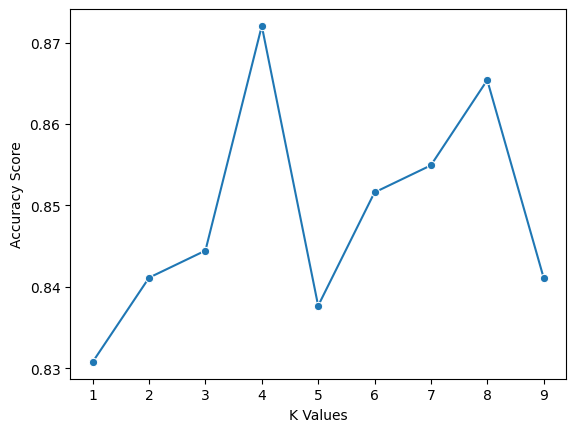

In [26]:
k_values = [i for i in range (1,10)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_pca, y, cv=10)
    scores.append(np.mean(score))

sns.lineplot(x = k_values, y=scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

**XGBClassifier MODEL**

In [27]:
from xgboost.sklearn import XGBClassifier

In [28]:

def evaluate_xgb_classifier(X_train, y_train, X_test, y_test):
    # Initialize the XGBClassifier
    model = XGBClassifier()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions for the test data
    y_pred = model.predict(X_test)

    # Round the predicted values to binary (0 or 1)
    y_pred = [round(value) for value in y_pred]

    # Evaluate predictions using accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # confusion matrix
    c_mat = confusion_matrix(y_test, y_pred)

    # Print the accuracy
    print("~"*10 + "XGB Classifier")
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(c_mat)
    print(classification_report(y_test, y_pred))

**ACCURACY RESULTS**

In [29]:
logistic_regression(X_train, y_train, X_test, y_test)
SVC(X_train, y_train, X_test, y_test)
KNN(X_train, y_train, X_test, y_test)
evaluate_xgb_classifier(X_train, y_train, X_test, y_test)

~~~~~~~~~~LOGISTIC REGRESSION
Accuracy: 84.95%
Confusion matrix: 
[[33  6]
 [ 5 29]]
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86        39
         1.0       0.83      0.85      0.84        34

    accuracy                           0.85        73
   macro avg       0.85      0.85      0.85        73
weighted avg       0.85      0.85      0.85        73

~~~~~~~~~~SVC
Accuracy: 82.19%
[[33  6]
 [ 7 27]]
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84        39
         1.0       0.82      0.79      0.81        34

    accuracy                           0.82        73
   macro avg       0.82      0.82      0.82        73
weighted avg       0.82      0.82      0.82        73

~~~~~~~~~~KNN
Accuracy: 86.30%
[[32  7]
 [ 3 31]]
              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86        39
         1.0       0.82      0.91      0.86        3